<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Gavrilkov%20Nikolay/internship_8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1-я стажировка "Профпатолог" новый датасет
Подключаем необходимые библиотеки, и зададим некоторые ф-ции


# Подготовка

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import pickle as pkl
#from datetime import datetime

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

#from tensorflow.keras.metrics import *

!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons import metrics

# Дополнительные инструменты
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from google.colab import data_table
data_table.enable_dataframe_formatter()

import random
import math
import os
import re
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 33.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Создадим несколько процедур для анализа данных датасета

In [2]:
# Для вывода подробной информации по колонке если послетдний параметр True - выведет количетвенное распределения по значениям в колонке.
def info_col (row, df, x=False):
    cols = df.columns.tolist()
    print(f'Заполнено: {df[cols[row]].count()} ячеек ({round(df[cols[row]].count()*100/df.shape[0],2)}%), уникальных записей: {df[cols[row]].nunique()}')
    if x :
        print(df[cols[row]].unique())
    else:
        print(df[cols[row]].value_counts())
    print('Тип данных: ', df[cols[row]].dtypes)
    return

In [3]:
# Проверка влияния значения в колонеке на конечный результат для анализа "важности" колонки.
def viev_row(df,row, val, rows = []):
    rowses = list(['ЗаключениеМК'])
    rowses.extend(rows)
    if row not in rowses:
        rowses.append(row)
    display(df[(df[row] == val)][rowses])
    return


In [4]:
# небольшая ф-ция по слиянию колонок, содержащих одинаковые данные т.е. если в целевой колонке строка не заполнена, а в одной из
# колонок из списка имеются данные, они будут скопированы в целевую колонку.
def col_concat (df,row, list_row):
    for row1 in list_row:
        print(f'{row} было заполнено - {df[row].count()}')
        df.loc[df_cor[row].isna(),[row]] = df[row1]
        print(f'{row} + {row1} стало - {df_cor[row].count()}')
    return df

In [5]:
#Процедура размножения минорного класса: принимает как параметр df - датасет,
#row - название колонки, val - Значение которое нужно размножить,
# val_to - Значение по которому размножает до koef - коэфициент соотношения к минорному классу.
def balance_data(df,row,val,val_to,koef=0.25):
    print(f'Было - {df.shape}')
    df_x = df.loc[df[row]==val]
    ratio = len(df.loc[df[row]==val_to])*koef//len(df.loc[df[row]==val])
    df_x = df_x.loc[df_x.index.repeat(ratio)]
    df= pd.concat([df, df_x]).sample(frac=1)
    print(f'Стало - {df.shape}')

    return df

In [6]:
# Процедура поочередного преобразования колонок ОНЕ через LabelEncoder в ОНЕ
# все это соберем в один масив x_data
def df_to_ohe(df,lstrow):
    list_encoders = {}
    list_code = []
    for i in range(len(lstrow)):
        encoder = LabelEncoder()
        list_code.append(utils.to_categorical(encoder.fit_transform(df[lstrow[i]].tolist()),df[lstrow[i]].nunique()))
        list_encoders[lstrow[i]] = encoder
    x_data = np.hstack(list_code)
    return x_data, list_code, list_encoders


In [7]:
# Объединение родственных колонок по специалистам, используя написанную ранее процедуру col_concat()
# с последующим удалением использованных колонок.
def df_row_concat(df, lst1, lst2):
    for elm1 in lst1:
        cols1_list = df.columns.tolist()  # Пересоздаем список колонок чтобы исключить удаленные
        tst_list = []
        for elm in cols1_list:
            if elm1 in elm:
                tst_list.append(elm)
        for elm2 in lst2:
            conc_list = []
            for elm in tst_list:
                if elm2 in elm:
                    conc_list.append(elm)
            if len(conc_list) > 1:
                row_con = conc_list.pop(0)
                print(f'объединение колонки {row_con} с колонками {conc_list}')
                col_concat(row_con, conc_list)
                df = df.drop(conc_list, axis=1)
    return df

In [8]:
# Процедура вычисления возраста, занесение его в категориальном виде в отд колонку, удаление колонки Дата рождения
def set_age (df,row1,row2):
    cols = df.columns.to_list()
    data1 = df[cols[row2]].tolist()
    data2 = df[cols[row1]].tolist()
    age = []
    for i in range(len(data1)):
        age.append((int(re.search('\d{4}',data1[i])[0]) - int(re.search('\d{4}',data2[i])[0])-12)//7)

    df.insert(2,'AGE',age)
    df = df.drop([cols[row1]], axis=1)
    return df

In [9]:
# Удаление незаполненных строк в колонке с указанным индексом, если индекс не указан обрабатывается колонка "ЗаключениеМК"
def clear_df (df, col_idx=12):
    col_names = df.columns.to_list()
    print(f'Обрабатывается датафрейм размерностью {df.shape}, не заполнено: {df[col_names[col_idx]].isna().sum()} ячеек')
    df = df.drop(df[df[col_names[col_idx]].isna()].index)
    df = df.drop(df[df[col_names[col_idx]] == ' п. 11.3'].index)
    print(f'Новая размерность: {df.shape}')
    return df


# Загрузка dataset-а и предварительная обработка


In [ ]:
# Создадим список датафреймов и загрузим в него наши датасеты
df = list()
for name in os.listdir('/content/drive/MyDrive/profpatolog/New_dataset'):
    name = '/content/drive/MyDrive/profpatolog/New_dataset/'+name
    tmp_df = pd.read_csv(name,sep=';',header=None, nrows=5)
    tmp_shape = tmp_df.shape[1]
    if tmp_df.iloc[0,0] == 'ДокументПрохождениеМедосмотра':
        df.append(pd.read_csv(name,sep=';'))
    else:
        df.append(pd.read_csv(name,sep=';',header=None, usecols=[i for i in range(tmp_shape)]))

len(df)

<ipython-input-10-5eaa146d6d6f>:10: DtypeWarning: Columns (54,80,81,82,83,84,85,98,99,100,101,102,103,106,107,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df.append(pd.read_csv(name,sep=';',header=None, usecols=[i for i in range(tmp_shape)]))
<ipython-input-10-5ea

17

In [ ]:
# Для начала удалим строки где нет заключения
for i in range(len(df)):
    df[i] = clear_df (df[i])


Обрабатывается датафрейм размерностью (1502, 430), не заполнено: 447 ячеек
Новая размерность: (1055, 430)
Обрабатывается датафрейм размерностью (1041, 190), не заполнено: 792 ячеек
Новая размерность: (249, 190)
Обрабатывается датафрейм размерностью (1434, 294), не заполнено: 997 ячеек
Новая размерность: (437, 294)
Обрабатывается датафрейм размерностью (1850, 306), не заполнено: 852 ячеек
Новая размерность: (998, 306)
Обрабатывается датафрейм размерностью (1363, 290), не заполнено: 247 ячеек
Новая размерность: (1116, 290)
Обрабатывается датафрейм размерностью (1421, 266), не заполнено: 680 ячеек
Новая размерность: (741, 266)
Обрабатывается датафрейм размерностью (2533, 296), не заполнено: 1502 ячеек
Новая размерность: (1031, 296)
Обрабатывается датафрейм размерностью (1891, 458), не заполнено: 287 ячеек
Новая размерность: (1604, 458)
Обрабатывается датафрейм размерностью (1070, 218), не заполнено: 504 ячеек
Новая размерность: (566, 218)
Обрабатывается датафрейм размерностью (1832, 262),

Учитывая очень разношорсттные датасеты решил попробовать обойтись тем что нам предоставили. А именно:

*   Колонки с 0 по 15 у всех совпадают. Хоть и не все, но будем их использовать как есть
*   Колонок с числовыми данными не нашел потому от числовой ветки в модели нейронки откажемся.
*   Учитывая, что колонки не подписаны по специалистам решил собрать все коды МКБ в одну и также поступить с диагнозами (тем более что некоторым клиентам специалисты ставили по несколько диагнозов)
*   колонку с МКБ буду обрабатывать не как MHE а как BagOfWords на случай если встретится код который не учавствовал в кодировании.
*   там где есть "Описание" выделю в отдельную колонку.
*   колонки буду едентифицировать по ключевым словам.
*   не нашел ни одной колонки с рекомендациями, потому с конкретными рекомендациями как прошлом ноутбуке прийдется распрошаться, можно будет давать только общие.

In [ ]:
df[1].head()

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Стоматология3_МКБ101,Стоматология3_ДиагнозПредставление1,Стоматология3_Диагноз_Значение,Стоматология3_Диагноз_ЗначениеПредставление,Хирургия2_ДокументПрием,Хирургия2_ДатаПриема,Хирургия2_МКБ101,Хирургия2_ДиагнозПредставление1,Хирургия2_Диагноз_Значение,Хирургия2_Диагноз_ЗначениеПредставление
0,8ad4616c-0b5b-11ee-8133-0cc47aab8067,2264f308-b78c-11ea-80dd-0cc47aab8067,1980-08-29T00:00:00,Мужской,Мужской,2023-04-06T00:00:00,Периодический,Периодический,False,961bfdc2-9d18-11eb-80eb-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bd94cd34-0b62-11ee-8133-0cc47aab8067,b1ebfc4c-a367-11ec-80ff-0cc47aab8067,1988-02-12T00:00:00,Мужской,Мужской,2023-04-06T00:00:00,Периодический,Периодический,False,961bfdc2-9d18-11eb-80eb-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02a95076-0b63-11ee-8133-0cc47aab8067,28b3b8f4-c23c-11ec-8100-0cc47aab8067,1980-08-26T00:00:00,Мужской,Мужской,2023-04-06T00:00:00,Периодический,Периодический,False,961bfdc2-9d18-11eb-80eb-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cb61c14c-0b6d-11ee-8133-0cc47aab8067,300cb78c-da36-11eb-80f6-0cc47aab8067,1983-02-22T00:00:00,Мужской,Мужской,2023-04-06T00:00:00,Периодический,Периодический,False,961bfdc2-9d18-11eb-80eb-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1ab6ecd0-0b64-11ee-8133-0cc47aab8067,5755a71d-db14-11ec-8100-0cc47aab8067,1995-01-24T00:00:00,Мужской,Мужской,2023-04-06T00:00:00,Периодический,Периодический,False,961bfdc2-9d18-11eb-80eb-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Удалим колонки не имеющие записей
for i in range(len(df)):
    print(f'Размер до - {df[i].shape}')
    df[i] = df[i].dropna(axis=1, how='all')
    print(f'Размер после - {df[i].shape}')

Размер до - (1055, 430)
Размер после - (1055, 421)
Размер до - (249, 190)
Размер после - (249, 154)
Размер до - (437, 294)
Размер после - (437, 274)
Размер до - (998, 306)
Размер после - (998, 296)
Размер до - (1116, 290)
Размер после - (1116, 290)
Размер до - (741, 266)
Размер после - (741, 246)
Размер до - (1031, 296)
Размер после - (1031, 290)
Размер до - (1604, 458)
Размер после - (1604, 444)
Размер до - (566, 218)
Размер после - (566, 206)
Размер до - (1054, 262)
Размер после - (1054, 260)
Размер до - (1191, 342)
Размер после - (1191, 326)
Размер до - (1247, 446)
Размер после - (1247, 426)
Размер до - (1187, 304)
Размер после - (1187, 294)
Размер до - (763, 228)
Размер после - (763, 210)
Размер до - (1088, 258)
Размер после - (1088, 254)
Размер до - (471, 222)
Размер после - (471, 220)
Размер до - (1416, 310)
Размер после - (1416, 308)


In [ ]:
# Уточнение процента заполненности датафреймов
for i in range(len(df)):
    print(f'Датафрейм {str(i+1)} не заполнено {round(df[i].isna().sum().sum() * 100 / df[i].size,2)} %')

Датафрейм 1 не заполнено 85.58 %
Датафрейм 2 не заполнено 65.15 %
Датафрейм 3 не заполнено 81.76 %
Датафрейм 4 не заполнено 82.15 %
Датафрейм 5 не заполнено 78.65 %
Датафрейм 6 не заполнено 78.14 %
Датафрейм 7 не заполнено 82.65 %
Датафрейм 8 не заполнено 86.65 %
Датафрейм 9 не заполнено 72.76 %
Датафрейм 10 не заполнено 77.35 %
Датафрейм 11 не заполнено 83.28 %
Датафрейм 12 не заполнено 89.47 %
Датафрейм 13 не заполнено 78.88 %
Датафрейм 14 не заполнено 73.55 %
Датафрейм 15 не заполнено 79.56 %
Датафрейм 16 не заполнено 76.1 %
Датафрейм 17 не заполнено 84.09 %


In [ ]:
# Прогверим заполненность колонки с датой рождения и датой прохождения осмотра (нужно для вычисления возраста)
for i in range(len(df)):
    cols = df[i].columns.tolist()
    print(f'Датафрейм {i+1} Колонка дата родения - Заполнено: {df[i][cols[2]].count()} ячеек из {df[i].shape[0]} или {round(df[i][cols[2]].count()*100/df[i].shape[0],2)}%')
    print(f'Датафрейм {i+1} Колонка дата медосмотра - Заполнено: {df[i][cols[5]].count()} ячеек из {df[i].shape[0]} или {round(df[i][cols[5]].count()*100/df[i].shape[0],2)}%')
    print('--------')

Датафрейм 1 Колонка дата родения - Заполнено: 1054 ячеек из 1055 или 99.91%
Датафрейм 1 Колонка дата медосмотра - Заполнено: 1055 ячеек из 1055 или 100.0%
--------
Датафрейм 2 Колонка дата родения - Заполнено: 249 ячеек из 249 или 100.0%
Датафрейм 2 Колонка дата медосмотра - Заполнено: 249 ячеек из 249 или 100.0%
--------
Датафрейм 3 Колонка дата родения - Заполнено: 437 ячеек из 437 или 100.0%
Датафрейм 3 Колонка дата медосмотра - Заполнено: 437 ячеек из 437 или 100.0%
--------
Датафрейм 4 Колонка дата родения - Заполнено: 996 ячеек из 998 или 99.8%
Датафрейм 4 Колонка дата медосмотра - Заполнено: 998 ячеек из 998 или 100.0%
--------
Датафрейм 5 Колонка дата родения - Заполнено: 1116 ячеек из 1116 или 100.0%
Датафрейм 5 Колонка дата медосмотра - Заполнено: 1116 ячеек из 1116 или 100.0%
--------
Датафрейм 6 Колонка дата родения - Заполнено: 740 ячеек из 741 или 99.87%
Датафрейм 6 Колонка дата медосмотра - Заполнено: 741 ячеек из 741 или 100.0%
--------
Датафрейм 7 Колонка дата родения 

In [ ]:
# Дозаполним незаполненные даты датой '1983-01-01T00:00:00' т.е. нарисуем им по 40 лет
for i in range(len(df)):
    cols = df[i].columns.tolist()
    df[i][cols[2]] = df[i][cols[2]].fillna('1983-01-01T00:00:00')


In [ ]:
# Прогверим заполненность колонки с датой рождения и датой прохождения осмотра (нужно для вычисления возраста)
for i in range(len(df)):
    cols = df[i].columns.tolist()
    print(f'Датафрейм {i+1} Колонка дата родения - Заполнено: {df[i][cols[2]].count()} ячеек из {df[i].shape[0]} или {round(df[i][cols[2]].count()*100/df[i].shape[0],2)}%')
    print(f'Датафрейм {i+1} Колонка дата медосмотра - Заполнено: {df[i][cols[5]].count()} ячеек из {df[i].shape[0]} или {round(df[i][cols[5]].count()*100/df[i].shape[0],2)}%')
    print('--------')

Датафрейм 1 Колонка дата родения - Заполнено: 1055 ячеек из 1055 или 100.0%
Датафрейм 1 Колонка дата медосмотра - Заполнено: 1055 ячеек из 1055 или 100.0%
--------
Датафрейм 2 Колонка дата родения - Заполнено: 249 ячеек из 249 или 100.0%
Датафрейм 2 Колонка дата медосмотра - Заполнено: 249 ячеек из 249 или 100.0%
--------
Датафрейм 3 Колонка дата родения - Заполнено: 437 ячеек из 437 или 100.0%
Датафрейм 3 Колонка дата медосмотра - Заполнено: 437 ячеек из 437 или 100.0%
--------
Датафрейм 4 Колонка дата родения - Заполнено: 998 ячеек из 998 или 100.0%
Датафрейм 4 Колонка дата медосмотра - Заполнено: 998 ячеек из 998 или 100.0%
--------
Датафрейм 5 Колонка дата родения - Заполнено: 1116 ячеек из 1116 или 100.0%
Датафрейм 5 Колонка дата медосмотра - Заполнено: 1116 ячеек из 1116 или 100.0%
--------
Датафрейм 6 Колонка дата родения - Заполнено: 741 ячеек из 741 или 100.0%
Датафрейм 6 Колонка дата медосмотра - Заполнено: 741 ячеек из 741 или 100.0%
--------
Датафрейм 7 Колонка дата родения

In [ ]:
# Введем на место колонки "ДатаРождения" колонку "AGE" содержащую возраст в кодированном виде
for i in range(len(df)):
    df[i] = set_age (df[i],2,5)

In [ ]:
df[2].head()

,0,1,AGE,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,292,293
0,1ab546f9-cc4a-11e8-80ce-0cc47aab8067,d038b83f-e137-11e6-80d2-708bcd7f83cd,3,Мужской,Мужской,2018-10-10T00:00:00,Периодический,Периодический,False,3ad89617-15c8-11e6-bae4-60a44c4fed07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d521bbed-7ca5-11eb-80e8-0cc47aab8067,85c57f05-0f14-11e7-80d3-708bcd7f83cd,5,Женский,Женский,2021-03-04T00:00:00,Периодический,Периодический,False,1f3ea446-2cf9-11e8-80c9-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,faa7ea12-7ca0-11eb-80e8-0cc47aab8067,bab81f48-2cf9-11e8-80c9-0cc47aab8067,2,Женский,Женский,2021-03-04T00:00:00,Периодический,Периодический,False,1f3ea446-2cf9-11e8-80c9-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3fd4011f-7c9f-11eb-80e8-0cc47aab8067,85c57f07-0f14-11e7-80d3-708bcd7f83cd,6,Женский,Женский,2021-03-04T00:00:00,Периодический,Периодический,False,1f3ea446-2cf9-11e8-80c9-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,399a7049-7c9b-11eb-80e8-0cc47aab8067,85c57f06-0f14-11e7-80d3-708bcd7f83cd,6,Женский,Женский,2021-03-04T00:00:00,Периодический,Периодический,False,1f3ea446-2cf9-11e8-80c9-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Приведение к 3 классам методом map()
for i in range(len(df)):
    cols = df[i].columns.tolist()
    new_val = {'ГоденСКоррекциейСлуха':'ОграниченноГоден','ГоденСКоррекциейЗрения':'ОграниченноГоден','ГоденБезРаботНаВысотах':'ОграниченноГоден','НуждаетсяВДообследованииИЛечении':'Негоден','ВременноНегоден':'Негоден','Годен':'Годен','ОграниченноГоден':'ОграниченноГоден','Негоден':'Негоден'}
    df[i][cols[12]] = df[i][cols[12]].map(new_val)

In [ ]:
# Посмотрим что получилось.
for i in range(len(df)):
    info_col(12,df[i])

Заполнено: 1055 ячеек (100.0%), уникальных записей: 3
Годен               1001
ОграниченноГоден      47
Негоден                7
Name: 12, dtype: int64
Тип данных:  object
Заполнено: 249 ячеек (100.0%), уникальных записей: 3
Годен               233
ОграниченноГоден     12
Негоден               4
Name: ЗаключениеМК, dtype: int64
Тип данных:  object
Заполнено: 437 ячеек (100.0%), уникальных записей: 3
Годен               416
ОграниченноГоден     20
Негоден               1
Name: 12, dtype: int64
Тип данных:  object
Заполнено: 998 ячеек (100.0%), уникальных записей: 3
Годен               937
ОграниченноГоден     59
Негоден               2
Name: 12, dtype: int64
Тип данных:  object
Заполнено: 1116 ячеек (100.0%), уникальных записей: 3
Годен               1027
ОграниченноГоден      79
Негоден               10
Name: 12, dtype: int64
Тип данных:  object
Заполнено: 741 ячеек (100.0%), уникальных записей: 3
Годен               696
ОграниченноГоден     37
Негоден               8
Name: 12, dtype: 

## поверка возможности объединения колонок по типу

In [ ]:
# Проверим вариант разбора колонок на примере отдельновзятого датасета - df[0]
cols = df[0].columns.tolist()
mkb = list()
diagnoz = list()
mkb_dz = list()
diagnoz_dz = list()
klass = list()
opis = list()
match_all = list()
m = 0
for col in range(16,len(cols)):
    tmp_data = df[0][cols[col]].unique()
    for n in range(tmp_data.shape[0]):
        if tmp_data[n] == 'Z00.0':  # Колонка с данными МКБ
            df[0][cols[col]] = df[0][cols[col]].fillna('Z99.9')   # Незаполненные ячейки заполним выдуманной категорией "Z99.9"
            mkb.append(df[0][cols[col]].to_list())
            continue # Доработать
        elif tmp_data[n] == 'Общий медицинский осмотр':     # Колонка с Диагнозами
            df[0][cols[col]] = df[0][cols[col]].fillna('Без диагноза')      # Незаполненные ячейки заполним значением "Без диагноза"
            diagnoz.append(df[0][cols[col]].to_list())
            continue
        elif tmp_data[n] == '[Z00.0] Общий медицинский осмотр\r\n':      # Колонка  Диагноз_Значение
            df[0][cols[col]] = df[0][cols[col]].fillna('[Z99.9] Без диагноза')      # Незаполненные ячейки заполним комбинированным значением "[Z99.9] Без диагноза"
            match_all.append(df[0][cols[col]].to_list())
            #m += 1
            #for ind in range(df[0].shape[0]):
            #    match1 = re.findall(r'\[([A-Z]\d\d\.\d)\]', str()))
            continue


for k in range(len(mkb[0])):
    for i in range(1,len(mkb)):
        if mkb[i][k] not in mkb[0][k]:
            mkb[0][k] += ' ' + mkb[i][k]

mkb_all = mkb[0]

for k in range(len(diagnoz[0])):
    for i in range(1,len(diagnoz)):
        if diagnoz[i][k] not in diagnoz[0][k]:
            diagnoz[0][k] += ' ' + diagnoz[i][k]

diagnoz_all = diagnoz[0]

for k in range(len(match_all)):
    for i in range(len(match_all[k])):
        match_tmp = re.findall(r'\[([A-Z]\d\d\.\d)\] (.+)\r\n(?:Классификация: (.*)\r\n)*(?:Описание: (.*)\r\n)*', match_all[k][i])
        for m in range(len(match_tmp)):
            if len(match_tmp[m][0]) > 0:
                if match_tmp[m][0] not in mkb_all[i]:
                    mkb_all[i] += ' ' + match_tmp[m][0]
            if len(match_tmp[m][3]) > 0:
                if match_tmp[m][3] not in diagnoz_all[i]:
                    diagnoz_all[i] += ' ' + match_tmp[m][3]
            if len(match_tmp[m][1]) > 0:
                if match_tmp[m][1] not in diagnoz_all[i]:
                    diagnoz_all[i] += ' ' + match_tmp[m][1]


In [ ]:
print(df[0].shape)
print(len(mkb))
print(len(diagnoz[0]))
print(diagnoz_all[76])
print(mkb_all[1015])
print(len(match_all))


(1055, 421)
107
1055
Общий медицинский осмотр Без диагноза Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности Астигматизм Простой миопический астигматизм ОИ
Z00.0 Z99.9 K04.5 K02.1 K05.3
60


In [ ]:
# Эксперименты с регулярными выражениями ind 1015, 76 row 32, 72
row = 32
ind = 1015
match1 = re.findall(r'\[([A-Z]\d\d\.\d)\]', df[0].iloc[ind,row])
match1_3 = re.findall(r'\[([A-Z]\d\d\.\d)\] (.+)\r\n(?:Классификация: (.*)\r\n)*(?:Описание: (.*)\r\n)*', df[0].iloc[ind,row])
match2 = re.findall(r'\[[A-Z]\d\d\.\d\] (.+)\r', df[0].iloc[ind,row])
match2_3 = re.findall(r'\[[A-Z]\d\d\.\d\] (.+)\r\n(?:Классификация: (.*)\r)*', df[0].iloc[ind,row])
match3 = re.findall(r'Классификация: (.*)\r', df[0].iloc[ind,row])
print(match1)
print(match1_3)
print(match2)
print(match2_3)
print(match3)
match_str = ' '.join(match1)
print(match_str)
print(match1_3[0][1])

['K04.5', 'K02.1', 'K05.3']
[('K04.5', 'Хронический апикальный периодонтит (Апикальная гранулема)', 'Заключительный клинический, ', ''), ('K02.1', 'Кариес дентина', 'Заключительный клинический, ', ''), ('K05.3', 'Хронический пародонтит', '', '')]
['Хронический апикальный периодонтит (Апикальная гранулема)', 'Кариес дентина', 'Хронический пародонтит']
[('Хронический апикальный периодонтит (Апикальная гранулема)', 'Заключительный клинический, '), ('Кариес дентина', 'Заключительный клинический, '), ('Хронический пародонтит', '')]
['Заключительный клинический, ', 'Заключительный клинический, ']
K04.5 K02.1 K05.3
Хронический апикальный периодонтит (Апикальная гранулема)


In [ ]:
df[0].iloc[:,[2,4,10,11,12,15,16,17]]

,AGE,4,10,11,12,15,16,17
0,6,Женский,NaN,Уборщик производственных помещений 2 разряда,Годен,23,47c0a2b1-7513-11ec-80fc-0cc47aab8067,2022-01-14T13:23:42
1,5,Женский,NaN,Оператор расфасовочно-упаковочного автомата 4 ...,Годен,23,b4a3645d-7511-11ec-80fc-0cc47aab8067,2022-01-14T13:12:27
2,6,Мужской,NaN,Водитель автомобиля 4 разряда,Годен,"18.1,23",f1b2ecab-83db-11ec-80fc-0cc47aab8067,2022-02-02T08:55:22
3,7,Женский,NaN,Оператор расфасовочно-упаковочного автомата 4 ...,Годен,23,a313b36c-95fd-11ec-80fe-0cc47aab8067,2022-02-25T10:41:57
4,6,Женский,NaN,Продавец продовольственных товаров 4 разряда,Годен,23,6042fb93-a10a-11ec-80ff-0cc47aab8067,2022-03-11T12:10:51
...,...,...,...,...,...,...,...,...
1480,3,Мужской,Отдел газодинамических и газоконденсатных иссл...,Оператор по исследованию скважин,Годен,"1.30.1,4.2.5,4.3.1,4.3.2,4.4,4.7,5.1,6.2,11.1,...",db6e9e84-ec03-4ac5-8a8b-a3c106a959c3,2023-03-31T08:52:45
1498,6,Мужской,NaN,Монтажник технологических трубопроводов,Негоден,"4.4,5.1,6.1,11.4,15",76b71f92-6f6e-4a6d-a79c-c5509ee624fd,2023-03-29T13:30:51
1499,5,Женский,Ооо «территория еды 102»,Повар,Годен,23,1cfc226f-46a2-4fe9-bcd9-af7e79c0956c,2023-03-28T12:15:39
1500,3,Женский,025-Уфа,Работник торгового зала - укладчик,Годен,"18.1,23",d1085eb4-f834-4ce2-9f99-1bd433d16d18,2023-03-10T13:24:33


## Реализация на всех датасетах

In [ ]:
# Перебор всех датафреймов, сокращение до отобранных колонок
for dfs in range(len(df)):
    cols = df[dfs].columns.tolist()
    mkb = list()
    mkb_dz = list()
    diagnoz = list()
    diagnoz_dz = list()
#    klass = list()
    match_all = list()
    for col in range(16,len(cols)):
        tmp_data = df[dfs][cols[col]].unique()
        for n in range(tmp_data.shape[0]):
            if tmp_data[n] == 'Z00.0':      # Колонка с данными МКБ
                df[dfs][cols[col]] = df[dfs][cols[col]].fillna('Z99.9')
                mkb.append(df[dfs][cols[col]].to_list())
                continue
            elif tmp_data[n] == 'Общий медицинский осмотр':         # Колонка с Диагнозами
                df[dfs][cols[col]] = df[dfs][cols[col]].fillna('Без диагноза')
                diagnoz.append(df[dfs][cols[col]].to_list())
                continue
            elif tmp_data[n] == '[Z00.0] Общий медицинский осмотр\r\n':     # Колонка  Диагноз_Значение
                df[dfs][cols[col]] = df[dfs][cols[col]].fillna('[Z99.9] Без диагноза')      # Незаполненные ячейки заполним комбинированным значением "[Z99.9] Без диагноза"
                match_all.append(df[dfs][cols[col]].to_list())
                continue
    mkb_all = list()
    for k in range(len(mkb[0])):
        mkb_all.append('')
        for i in range(len(mkb)):
            if mkb[i][k] not in mkb_all[k]:
                if mkb_all[k] == '':
                    mkb_all[k] = mkb[i][k]
                else:
                    mkb_all[k] += ' ' + mkb[i][k]

    for k in range(len(diagnoz[0])):
        for i in range(1,len(diagnoz)):
            if diagnoz[i][k] not in diagnoz[0][k]:
                diagnoz[0][k] += ' ' + diagnoz[i][k]

    diagnoz_all = diagnoz[0]

    for k in range(len(match_all)):
        for i in range(len(match_all[k])):
            match_tmp = re.findall(r'\[([A-Z]\d\d\.\d)\] (.+)\r\n(?:Классификация: (.*)\r\n)*(?:Описание: (.*)\r\n)*', match_all[k][i])
            for m in range(len(match_tmp)):
                if len(match_tmp[m][0]) > 0:
                    if match_tmp[m][0] not in mkb_all[i]:
                        mkb_all[i] += ' ' + match_tmp[m][0]
                if len(match_tmp[m][3]) > 0:
                    if match_tmp[m][3] not in diagnoz_all[i]:
                        diagnoz_all[i] += ' ' + match_tmp[m][3]
                if len(match_tmp[m][1]) > 0:
                    if match_tmp[m][1] not in diagnoz_all[i]:
                        diagnoz_all[i] += ' ' + match_tmp[m][1]

    df[dfs].insert(16,'MKB_ALL',mkb_all)
    df[dfs].insert(17,'DIAG_ALL',diagnoz_all)
    df[dfs] = df[dfs].iloc[:,[2,4,10,11,12,15,16,17]]

<ipython-input-127-4e65e96887af>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dfs].insert(16,'MKB_ALL',mkb_all)
<ipython-input-127-4e65e96887af>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dfs].insert(17,'DIAG_ALL',diagnoz_all)
<ipython-input-127-4e65e96887af>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [ ]:
df[1]

,AGE,КлиентПолПредставление,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,MKB_ALL,DIAG_ALL
0,4,Мужской,NaN,Водитель-экспедитор,Годен,"18.2,23,4.3.2,5.1,1.50",Z99.9,Без диагноза
1,3,Мужской,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,5.1,1.50",Z99.9,Без диагноза
2,4,Мужской,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,5.1,1.50",Z99.9,Без диагноза
3,4,Мужской,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,1.50,5.1",Z99.9,Без диагноза
4,2,Мужской,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,5.1,1.50",Z99.9,Без диагноза
...,...,...,...,...,...,...,...,...
870,3,Мужской,NaN,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",Z99.9,Без диагноза
871,1,Мужской,NaN,Водитель автомобиля,Годен,"23,18.2,4.3.2,5.1,1.50",Z99.9,Без диагноза
872,4,Мужской,NaN,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",Z99.9,Без диагноза
873,3,Мужской,NaN,Водитель автомобиля,Годен,"1.50,4.3.2,5.1,18.2,23",Z99.9,Без диагноза


In [ ]:
# Уточнение процента заполненности датафреймов
for i in range(len(df)):
    print(f'Датафрейм {str(i+1)} не заполнено {round(df[i].isna().sum().sum() * 100 / df[i].size,2)} %')

Датафрейм 1 не заполнено 7.58 %
Датафрейм 2 не заполнено 7.53 %
Датафрейм 3 не заполнено 10.1 %
Датафрейм 4 не заполнено 9.47 %
Датафрейм 5 не заполнено 6.93 %
Датафрейм 6 не заполнено 7.57 %
Датафрейм 7 не заполнено 8.77 %
Датафрейм 8 не заполнено 6.74 %
Датафрейм 9 не заполнено 8.22 %
Датафрейм 10 не заполнено 5.67 %
Датафрейм 11 не заполнено 7.69 %
Датафрейм 12 не заполнено 12.91 %
Датафрейм 13 не заполнено 9.3 %
Датафрейм 14 не заполнено 6.83 %
Датафрейм 15 не заполнено 8.35 %
Датафрейм 16 не заполнено 9.05 %
Датафрейм 17 не заполнено 8.49 %


In [ ]:
colls_name = df[1].columns.tolist()
for dfs in range(len(df)):
    df[dfs].columns = colls_name
df[0]

,AGE,КлиентПолПредставление,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,MKB_ALL,DIAG_ALL
0,6,Женский,NaN,Уборщик производственных помещений 2 разряда,Годен,23,Z00.0 Z99.9 N95.2,Общий медицинский осмотр Без диагноза постмено...
1,5,Женский,NaN,Оператор расфасовочно-упаковочного автомата 4 ...,Годен,23,Z00.0 Z99.9 I11.9 N95.1,Общий медицинский осмотр Без диагноза Гипертен...
2,6,Мужской,NaN,Водитель автомобиля 4 разряда,Годен,"18.1,23",Z00.0 Z99.9 H52.0,Общий медицинский осмотр Без диагноза Гипермет...
3,7,Женский,NaN,Оператор расфасовочно-упаковочного автомата 4 ...,Годен,23,Z00.0 Z99.9 I25.2 N95.2,Общий медицинский осмотр Без диагноза Перенесе...
4,6,Женский,NaN,Продавец продовольственных товаров 4 разряда,Годен,23,Z00.0 Z99.9,Общий медицинский осмотр Без диагноза
...,...,...,...,...,...,...,...,...
1480,3,Мужской,Отдел газодинамических и газоконденсатных иссл...,Оператор по исследованию скважин,Годен,"1.30.1,4.2.5,4.3.1,4.3.2,4.4,4.7,5.1,6.2,11.1,...",Z00.0 Z99.9 K29.5,Общий медицинский осмотр Без диагноза Хроничес...
1498,6,Мужской,NaN,Монтажник технологических трубопроводов,Негоден,"4.4,5.1,6.1,11.4,15",Z00.0 Z99.9 H52.0 K26.9 K29.5 R73.9,Общий медицинский осмотр Без диагноза Гипермет...
1499,5,Женский,Ооо «территория еды 102»,Повар,Годен,23,Z00.0 Z99.9 I11.9 N95.2,Общий медицинский осмотр Без диагноза Гипертен...
1500,3,Женский,025-Уфа,Работник торгового зала - укладчик,Годен,"18.1,23",Z00.0 Z99.9,Общий медицинский осмотр Без диагноза <>


In [ ]:
df[3]

,AGE,КлиентПолПредставление,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,MKB_ALL,DIAG_ALL
0,5,Мужской,NaN,токарь 6 р.,ОграниченноГоден,NaN,Z99.9,Без диагноза
1,1,Мужской,NaN,электро-сварщик ручной сварки 4 р.,Годен,NaN,Z00.0 Z99.9,Общий медицинский осмотр Без диагноза
2,4,Мужской,NaN,водитель автомобиля,Годен,NaN,Z99.9,Без диагноза
3,5,Мужской,NaN,токарь 6 р.,Годен,NaN,Z99.9,Без диагноза
4,5,Мужской,NaN,электро- сварщик ручной сварки 6 р.,Годен,NaN,Z00.0 Z99.9,Общий медицинский осмотр Без диагноза
...,...,...,...,...,...,...,...,...
1638,6,Мужской,Без отдела,Мастер,Годен,"9,26",Z00.0 Z99.9 K04.5,Общий медицинский осмотр Без диагноза Хроничес...
1782,1,Мужской,NaN,Повар,Годен,23,Z00.0 Z99.9,Общий медицинский осмотр Без диагноза
1799,1,Мужской,Без отдела,Мастер СМР,Годен,"4.7,4.8,5.1,6,17,26",Z00.0 Z99.9,Общий медицинский осмотр Без диагноза
1800,1,Мужской,Без отдела,Мастер СМР,Годен,"4.7,4.8,5.1,6,17",Z99.9 Z00.0,Без диагноза Общий медицинский осмотр


In [ ]:
df_all = pd.concat(df)
print(df_all.shape)

(16214, 8)


In [ ]:
# Балансировку
df_all['ЗаключениеМК'].value_counts()

Годен               15125
ОграниченноГоден      984
Негоден               105
Name: ЗаключениеМК, dtype: int64

In [ ]:
# Проверим балансировку датасета (соотношение Годен/НеГоден):
rat = len(df_all.loc[df_all['ЗаключениеМК']=='Годен'])//len(df_all.loc[df_all['ЗаключениеМК']=='Негоден'])
print(f'Соотношение заключений Годен к Негоден - {rat} к 1')

# Проверим балансировку датасета (соотношение Годен/ОграниченноГоден):
rat1 = len(df_all.loc[df_all['ЗаключениеМК']=='Годен'])//len(df_all.loc[df_all['ЗаключениеМК']=='ОграниченноГоден'])
print(f'Соотношение заключений Годен к ОграниченноГоден - {rat1} к 1')

Соотношение заключений Годен к Негоден - 144 к 1
Соотношение заключений Годен к ОграниченноГоден - 15 к 1


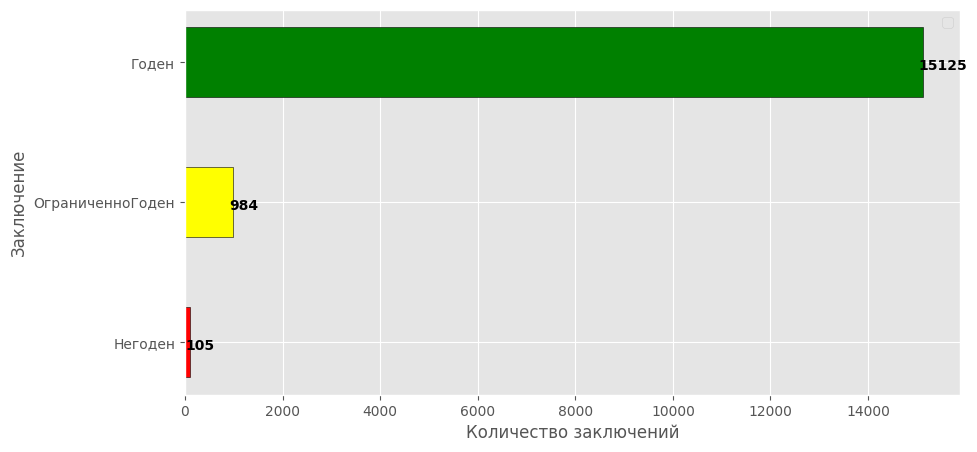

In [ ]:
# Соотношение ещё хуже чем в прошлом датасете, хотя кол-во стало больше
# Графическое представление:

y_axes = list(df_all['ЗаключениеМК'].value_counts().index.values)
x_axes = df_all['ЗаключениеМК'].value_counts().values
colors = ['green', 'yellow', 'r']
plt.figure(figsize = (10, 5))
plt.style.use('ggplot')
plt.barh(y_axes, x_axes, height=0.5, color=colors, edgecolor='black', linewidth=0.4)
for i, v in enumerate(x_axes):
    plt.text(v-85 if v>=90 else v+10, i + 0.05, str(v), color='black', fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel('Количество заключений')
plt.ylabel('Заключение')
plt.legend()
plt.show()

In [ ]:
print(f'Датафрейм общий не заполнено {round(df_all.isna().sum().sum() * 100 / df_all.size,2)} %')

Датафрейм общий не заполнено 8.29 %


In [ ]:
# Дозаполним некоторые колонки
df_all['ВредныеФакторы'] = df_all['ВредныеФакторы'].fillna('23')
df_all['Цех'] = df_all['Цех'].fillna('НетДанных')
print(f'Датафрейм общий не заполнено {round(df_all.isna().sum().sum() * 100 / df_all.size,2)} %')

Датафрейм общий не заполнено 0.0 %


In [ ]:
df_all.count()

AGE                       16214
КлиентПолПредставление    16211
Цех                       16214
Профессия                 16214
ЗаключениеМК              16214
ВредныеФакторы            16214
MKB_ALL                   16214
DIAG_ALL                  16214
dtype: int64

In [ ]:
df_all.to_csv('/content/drive/MyDrive/profpatolog/df_all.csv', index=False)

# Подготовка выборок для Обучения сети

In [ ]:
df_all = pd.read_csv('/content/drive/MyDrive/profpatolog/df_all.csv')
df_all.shape

(16214, 8)

In [ ]:
# Проведем колонку "Профессия" через токенайзер отбросим числа, чтобы не учитывать разряды и номера категорий, а только сами специальности.
words_spec = 1894
tokenizer_spec = Tokenizer(num_words=words_spec, filters='i1234567890!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_spec.fit_on_texts(df_all['Профессия'].tolist())
max(tokenizer_spec.word_index.values())

1894

In [ ]:
# Колонка "ВредныеФакторы" из фильтра исключим ".", чтобы индексы сохранились правильно
words_bed = 152
tokenizer_bed = Tokenizer(num_words=words_bed, filters='i!"#$%&()*+,-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='0.0.0', char_level=False)
tokenizer_bed.fit_on_texts(list(df_all['ВредныеФакторы']))
print(max(tokenizer_bed.word_index.values()))
print(tokenizer_bed.word_counts)

152
OrderedDict([('23', 4078), ('18.1', 2377), ('11.3', 978), ('26', 503), ('11.1', 3586), ('18.2', 1886), ('1.1', 565), ('1.3', 261), ('1.36.1', 197), ('1.39', 528), ('4.3.1', 1010), ('4.3.2', 1843), ('4.4', 3183), ('5.1', 4582), ('11.4', 2266), ('12', 671), ('18', 822), ('3.1.7', 569), ('8', 213), ('1.15', 183), ('4.7', 1678), ('6.2', 1755), ('17', 1187), ('3.1.9.3', 45), ('4.8', 867), ('6.1', 2688), ('1.14.2', 156), ('1.30.1', 194), ('1.37.1', 152), ('1.50', 991), ('9', 1563), ('4.2.5', 2575), ('15', 1332), ('1.48', 84), ('13', 668), ('1.53.2', 9), ('27', 744), ('4.1', 406), ('6', 1409), ('3.1.2', 137), ('4.2.1', 341), ('1.29.2', 329), ('14', 75), ('11', 274), ('4.2.3', 152), ('4.2.4', 95), ('4.5', 74), ('1.5.1', 38), ('1.51', 33), ('5.2', 127), ('25', 942), ('1.17', 75), ('1.23', 181), ('1.27.1', 64), ('4.2', 98), ('1.29.1', 86), ('3.1.1', 59), ('1.8.1.1', 90), ('1.8.1.2', 47), ('1.8.2.1', 31), ('1.8.2.2', 21), ('1.8.3.1', 21), ('1.8.3.2', 21), ('16', 7), ('24', 47), ('4.9', 167), 

In [ ]:
# Колонка "МКБ" из фильтра исключим ".", чтобы индексы сохранились правильно
words_mkb = 411
tokenizer_mkb = Tokenizer(num_words=words_mkb, filters='i!"#$%&()*+,-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='0.0.0', char_level=False)
tokenizer_mkb.fit_on_texts(list(df_all['MKB_ALL']))
print(max(tokenizer_mkb.word_index.values()))
print(tokenizer_mkb.word_counts)

411
OrderedDict([('z00.0', 13019), ('z99.9', 16214), ('n95.2', 296), ('11.9', 1981), ('n95.1', 164), ('h52.0', 686), ('25.2', 13), ('n84.1', 36), ('h90.3', 87), ('k04.5', 647), ('l40.0', 48), ('d25.9', 108), ('h52.1', 1967), ('48.1', 4), ('49.9', 9), ('d25', 127), ('k02.1', 921), ('n76.1', 32), ('f98.5', 3), ('67.2', 27), ('k29.7', 24), ('h52.2', 773), ('e11.9', 41), ('k05.3', 93), ('k29.5', 327), ('d50.9', 16), ('h90.4', 46), ('f06.8', 27), ('e22.1', 1), ('h74.1', 67), ('k81.8', 1), ('r73.9', 48), ('h26.1', 4), ('f06.6', 44), ('h50.8', 7), ('h53.0', 70), ('k40.2', 8), ('f60.3', 20), ('m05.9', 2), ('g25.0', 14), ('k29.6', 144), ('12.9', 3), ('h01.0', 8), ('k08.1', 6), ('m15.9', 3), ('g93.4', 1), ('q21.1', 1), ('k29.8', 59), ('n86', 21), ('n88.8', 1), ('48.2', 2), ('d18.0', 6), ('l21.9', 1), ('l40.9', 6), ('j45.9', 20), ('k26.9', 21), ('83.9', 24), ('h50.9', 7), ('n83.2', 22), ('69.3', 8), ('n70.9', 66), ('t90.4', 18), ('h50.0', 20), ('m42.1', 44), ('h35.0', 9), ('z32.1', 27), ('d31.9',

In [ ]:
df_all['Цех'].unique()

In [ ]:
# Рассортируем колонки
ohe_col = ['КлиентПолПредставление','AGE']

# Работа с датасетом "Весь период"

In [10]:
df_new = pd.read_csv('/content/drive/MyDrive/profpatolog/Весь период.csv', sep=';')

<ipython-input-10-bc1acf122085>:1: DtypeWarning: Columns (16,18,19,20,22,23,25,26,27,29,30,32,35,36,37,39,40,41,42,43,44,46,47,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,66,68,70,74,75,77,78,80,81,82,84,85,87,90,91,92,95,96,97,99,100,101,103,104,108,109,114,115,116,120,122,123,124,126,127,128,130,131,133,138,139,142,143,145,146,148,149,153,154,155,157,158,160,161,162,164,165,167,168,170,171,173,175,176,177,178,179,180,181,182,183,184,188,189,191,192,194,195,196,201,202,204,208,209,210,211,214,215,216,217,218,220,221,222,224,225,228,229,230,231,233,234,235,236,240,241,242,243,244,245,246,247,248,250,258,260,262,265,266,269,270,272,273,274,276,277,278,280,281,282,283,284,285,286,287,288) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv('/content/drive/MyDrive/profpatolog/Весь период.csv', sep=';')


In [11]:
print(df_new.columns.to_list())

['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения', 'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра', 'ТипМедосмотра', 'ТипМедосмотраПредставление', 'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия', 'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение', 'ВредныеФакторы', 'Гинекология1_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология1_МКБ101', 'Гинекология1_МКБ102', 'Гинекология1_МКБ103', 'Гинекология2_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология2_МКБ101', 'Гинекология2_МКБ102', 'Гинекология2_МКБ103', 'Гинекология3_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология3_МКБ101', 'Гинекология3_МКБ102', 'Гинекология3_МКБ103', 'Гинекология4_Диагноз_ЗначениеПредставлениеПредставление', 'Гинекология4_МКБ101', 'Гинекология4_МКБ102', 'ГинекологНеИсп1_Диагноз_ЗначениеПредставлениеПредставление', 'ГинекологНеИсп1_МКБ101', 'Дерматовенерология1_Диагноз_ЗначениеПредставлениеПредставление', 'Дерматовенерология1_МКБ101', 'Дерматов

In [12]:
df_new['ЗаключениеМК'].unique()

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', nan, 'ГоденБезРаботНаВысотах',
       'ГоденСКоррекциейСлуха', ' п. 11.3', 'ОграниченноГоден',
       'машинист бульдозера', 'Газоспасатель', ' Газоспасатель',
       'Негоден'], dtype=object)

In [13]:
#Удалим строки с ошибками заполнения ('машинист бульдозера', 'Газоспасатель',' Газоспасатель')
count_ind = df_new.shape[0]
for str1 in ('машинист бульдозера', 'Газоспасатель',' Газоспасатель',' п. 11.3'):
    df_new = df_new.drop(df_new[df_new['ЗаключениеМК'] == str1].index)
print(f'Удалено {count_ind - df_new.shape[0]} строк(и)')
df_new.shape

Удалено 5 строк(и)


(32681, 289)

In [14]:
df_new.head()

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,79292387-652a-11eb-80e7-0cc47aab8067,dca98d4e-2098-11ea-80d6-0cc47aab8067,1989-12-31T00:00:00,Женский,Женский,2021-02-02T00:00:00,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78efe744-9c36-11eb-80eb-0cc47aab8067,b35fb2bb-9c35-11eb-80eb-0cc47aab8067,1998-07-20T00:00:00,Женский,Женский,2021-04-13T00:00:00,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131f68ef-9c2d-11eb-80eb-0cc47aab8067,f8c98e39-9c2c-11eb-80eb-0cc47aab8067,2002-01-04T00:00:00,Женский,Женский,2021-04-13T00:00:00,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,941e4b56-9c2d-11eb-80eb-0cc47aab8067,7ea364a1-9c2d-11eb-80eb-0cc47aab8067,1991-08-26T00:00:00,Женский,Женский,2021-04-13T00:00:00,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5a24806c-f033-11eb-80f6-0cc47aab8067,52eb6a7d-c1ab-11ea-80dd-0cc47aab8067,1999-03-21T00:00:00,Женский,Женский,2021-07-29T00:00:00,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Проверим заполнение колонок с диагнозами
sel_col = []
for col in df_new.columns:
    if 'Диагноз' in col:
        sel_col.append(col)

df_new[sel_col].count()[0:30]

Гинекология1_Диагноз_ЗначениеПредставлениеПредставление              0
Гинекология2_Диагноз_ЗначениеПредставлениеПредставление              0
Гинекология3_Диагноз_ЗначениеПредставлениеПредставление              0
Гинекология4_Диагноз_ЗначениеПредставлениеПредставление              0
ГинекологНеИсп1_Диагноз_ЗначениеПредставлениеПредставление           0
Дерматовенерология1_Диагноз_ЗначениеПредставлениеПредставление       0
Дерматовенерология2_Диагноз_ЗначениеПредставлениеПредставление       0
Дерматовенерология3_Диагноз_ЗначениеПредставлениеПредставление       0
Дерматовенерология4_Диагноз_ЗначениеПредставлениеПредставление       0
ДерматовенерологНеИсп1_Диагноз_ЗначениеПредставлениеПредставление    0
ДерматовенерологНеИсп2_Диагноз_ЗначениеПредставлениеПредставление    0
Наркология1_Диагноз_ЗначениеПредставлениеПредставление               0
НаркологияНеИсп1_Диагноз_ЗначениеПредставлениеПредставление          0
НаркологНеИсп1_Диагноз_ЗначениеПредставлениеПредставление            0
Неврол

Колонки с диангозами не заполнены, получается текстовая ветка сетки тоже отключить...

In [16]:
df_new['ВредныеФакторы'].value_counts()[0:60]

23                                        4834
04.02.2005                                1695
25                                        1181
27                                         836
6.1,9,13                                   629
26                                         513
4.2.5,6.1,9                                475
05.янв                                     348
4.2.5,6.1,9,13                             336
22                                         329
4.4,5.1,6.2,11.1,11.4                      300
4.2.5,23                                   286
18.янв                                     281
18.фев                                     280
11.янв                                     238
4.2.5,9                                    231
18.1,22                                    201
6.1,9                                      190
15                                         187
4.3.1,4.3.2,4.4,18.1                       174
4.3.1,4.3.2,18.1                           163
5.1,23       

In [17]:
df_new['ВредныеФакторы'].unique()[:100]

array([nan, '04.окт', '23', '25', '4.4,5.1,15,6.1,11.4', '9,26', '18.фев',
       '3.1.7,1.1,1.23,1.39,4.4,5.1,11.1,6.1', '04.02.2005', 'янв.48',
       '4.2.5,27', '4.2.5,4.4,11.1,18.1', '5.1,6,9,11.1,11.4',
       '4.2.5,4.2.5', '4.2.5,6.1,9', '27', '11.1,11.1',
       '1.29.2,4.2.5,4.4,4.7,6.2,11.1', '1.29.2,4.1,4.3.2,11.1,11.4,18.2',
       '14', '1.50,11.3', '4.3.2,11.1,11.4,18.1,18.2',
       '5.1,6,17,5.1,6,17',
       '3.1.8,4.3.1,4.4,5.1,6,17,3.1.8,4.3.1,4.4,5.1,6,17',
       '4.4,5.1,11.1,6.1,15', '18.2,4.3.1,4.3.2',
       '4.7,5.1,6.2,11.1,12,13', '1.29.2,4.1,4.3.2,11.1,11.4',
       '1.29.2,4.1,4.3.2,11.1,11.4,17,18.2', '4.2.5,11.3,11.4',
       '4.2.5,23', '3.1.8,4.3.1,4.4,5.1,6,17', '5.1,6,17',
       '1.1,1.36,1.39,4.3.1,4.3.2,4.4,4.7,5.1,17,18.1,18.2',
       '5.1,6,17,26', '4.3.1,4.3.2,4.4,6.1,8', '4.2.5,4.7,5.1,6.1,9,18.1',
       '4.4,5.1,6,17', '4.2.5,6.2', '4.2.5,23,15,4.2.5,23,15',
       '1.29.2,4.7,4.2.5,4.4,4.1,11.4,6.2', '18.1,23',
       '18.1,4.3.1,4.3.2,4.

In [18]:
# Исправим ошибки заполнения колонки "ВредныеФакторы" (15-й) индекс
new_val = {'янв':'1','фев':'2','мар':'3','апр':'4','май':'5','июн':'6','июл':'7','авг':'8','сен':'9','окт':'10','ноя':'11','дек':'12','2002':'2','2003':'3','2004':'4','2005':'5','01':'1','02':'2','03':'3','04':'4','05':'5','06':'6','07':'7','08':'8','09':'9'}
for i in range(df_new.shape[0]):
    for key in new_val.keys():
        val = str(df_new.iloc[i,15])
        if val.find(key) != -1:
            val = val.replace(key,new_val[key])
            df_new.iloc[i,15] = val

In [19]:
print(f"Колонка дата родения - Заполнено: {df_new['КлиентДатаРождения'].count()} ячеек из {df_new.shape[0]} или {round(df_new['КлиентДатаРождения'].count()*100/df_new.shape[0],2)}%")
print(f"Колонка ДатаЗавершенияМедосмотра - Заполнено: {df_new['ДатаЗавершенияМедосмотра'].count()} ячеек из {df_new.shape[0]} или {round(df_new['ДатаЗавершенияМедосмотра'].count()*100/df_new.shape[0],2)}%")

Колонка дата родения - Заполнено: 32442 ячеек из 32681 или 99.27%
Колонка ДатаЗавершенияМедосмотра - Заполнено: 32681 ячеек из 32681 или 100.0%


In [21]:
# Чтиобы не получить неопределенные данные выставим всем у кого нет дату рождения 01.01.1988 т.е. на 2023 год - 35 лет
df_new['КлиентДатаРождения'] = df_new['КлиентДатаРождения'].fillna('1988-01-01T00:00:00')
# Проверка:
print(f"Колонка дата родения - Заполнено: {df_new['КлиентДатаРождения'].count()} ячеек из {df_new.shape[0]} или {round(df_new['КлиентДатаРождения'].count()*100/df_new.shape[0],2)}%")

Колонка дата родения - Заполнено: 32681 ячеек из 32681 или 100.0%


In [22]:
# Сократим дату рождения до года и посмотрим корректность заполнения
data1 = df_new['КлиентДатаРождения'].tolist()
for i in range(len(data1)):
    data1[i] = re.search('\d{4}',data1[i])[0]
df_new['КлиентДатаРождения'] = data1

In [ ]:
df_new['КлиентДатаРождения'].unique()

array(['1989', '1998', '2002', '1991', '1999', '2001', '1996', '1992',
       '1990', '1972', '1964', '1978', '1994', '1988', '1969', '1995',
       '1983', '1986', '1979', '1984', '1980', '1987', '1965', '1970',
       '1971', '1952', '1961', '1985', '1967', '1977', '1997', '1982',
       '1968', '1993', '1975', '1974', '1976', '1960', '1981', '1958',
       '1962', '1957', '2018', '1973', '1966', '1959', '2000', '1963',
       '2003', '2006', '1955', '1951', '1956', '1953', '1077', '1954',
       '2004', '2008', '0981', '2005', '1946', '2015', '1944', '1949',
       '1950', '2022', '1947', '1948', '1941', '1905', '0969', '2007'],
      dtype=object)

In [23]:
# Имеются ошибки заполнения (0981,1077,1905...) - исправляем
new_val = {'0969':'1969','0981':'1981','1077':'1977','1905':'2005','2022':'2002','2015':'2005','2018':'2008',}
df_new['КлиентДатаРождения'] = df_new['КлиентДатаРождения'].replace(new_val)

In [24]:
df_new['КлиентДатаРождения'].unique()

array(['1989', '1998', '2002', '1991', '1999', '2001', '1996', '1992',
       '1990', '1972', '1964', '1978', '1994', '1988', '1969', '1995',
       '1983', '1986', '1979', '1984', '1980', '1987', '1965', '1970',
       '1971', '1952', '1961', '1985', '1967', '1977', '1997', '1982',
       '1968', '1993', '1975', '1974', '1976', '1960', '1981', '1958',
       '1962', '1957', '2008', '1973', '1966', '1959', '2000', '1963',
       '2003', '2006', '1955', '1951', '1956', '1953', '1954', '2004',
       '2005', '1946', '1944', '1949', '1950', '1947', '1948', '1941',
       '2007'], dtype=object)

In [25]:
# ТАкже поступим с колонкой датамедосмотра
data1 = df_new['ДатаЗавершенияМедосмотра'].tolist()
for i in range(len(data1)):
    data1[i] = re.search('\d{4}',data1[i])[0]
df_new['ДатаЗавершенияМедосмотра'] = data1

In [26]:
df_new['ДатаЗавершенияМедосмотра'].unique()

array(['2021', '2022', '2018', '2019', '2020', '2023'], dtype=object)

In [27]:
# Заменим колонку "КлиентДатаРождения" на колонку возраст "AGE" в формате под AHE
row1 = df_new.columns.get_loc('КлиентДатаРождения')
row2 = df_new.columns.get_loc('ДатаЗавершенияМедосмотра')
df_new = set_age (df_new,row1,row2)

In [28]:
df_new['AGE'].unique()

array([2, 1, 5, 6, 4, 3, 8, 7, 0, 9])

In [29]:
df_new

,ДокументПрохождениеМедосмотра,Клиент,AGE,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
0,79292387-652a-11eb-80e7-0cc47aab8067,dca98d4e-2098-11ea-80d6-0cc47aab8067,2,Женский,Женский,2021,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78efe744-9c36-11eb-80eb-0cc47aab8067,b35fb2bb-9c35-11eb-80eb-0cc47aab8067,1,Женский,Женский,2021,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131f68ef-9c2d-11eb-80eb-0cc47aab8067,f8c98e39-9c2c-11eb-80eb-0cc47aab8067,1,Женский,Женский,2021,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,941e4b56-9c2d-11eb-80eb-0cc47aab8067,7ea364a1-9c2d-11eb-80eb-0cc47aab8067,2,Женский,Женский,2021,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5a24806c-f033-11eb-80f6-0cc47aab8067,52eb6a7d-c1ab-11ea-80dd-0cc47aab8067,1,Женский,Женский,2021,Периодический,Периодический,False,3d01b2d6-ae08-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,0dc1a36a-0e78-11ee-8133-0cc47aab8067,c31ae865-e5bb-11ed-812b-0cc47aab8067,5,Мужской,Мужской,2023,Периодический,Периодический,False,2e01d3ec-615e-11eb-80e7-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32682,43a376cb-0e53-11ee-8133-0cc47aab8067,71fb1a04-28f6-11e7-80d5-708bcd7f83cd,4,Мужской,Мужской,2023,Периодический,Периодический,False,e935abf8-4ed4-11e9-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32683,f2163f48-0e61-11ee-8133-0cc47aab8067,c5c58eaf-cb1b-11ea-80e0-0cc47aab8067,2,Женский,Женский,2023,Периодический,Периодический,False,250639b6-68c4-11e8-80ce-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32684,346a9c13-0e65-11ee-8133-0cc47aab8067,d942cc21-e669-11ec-8102-0cc47aab8067,5,Мужской,Мужской,2023,Периодический,Периодический,False,c9d539ae-91a3-11e9-80cf-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Отберем колонки с МКБ
sel_col = []
for col in df_new.columns:
    if 'МКБ' in col:
        sel_col.append(col)

print(f"Отобрано {len(sel_col)} колонок")

Отобрано 210 колонок


In [31]:
# Дозаполним колонки МКБ нейтральными значениями и сведем все колонки в одну.
df_new[sel_col] = df_new[sel_col].fillna('Z99.9')

mkb = df_new[sel_col].values

mkb_all = list()
for k in range(mkb.shape[0]):
    mkb_all.append('')
    for i in range(mkb.shape[1]):
        if mkb[k,i] not in mkb_all[k]:
            if mkb_all[k] == '':
                mkb_all[k] = mkb[k,i]
            else:
                mkb_all[k] += ' ' + mkb[k,i]
print(len(mkb_all))

32681


In [32]:
mxl = 1
indx = 0
for i in range(len(mkb_all)):
    if len(mkb_all[i]) > mxl:
        mxl = len(mkb_all[i])
        indx = i
print(f"Максимальная длина - {mxl} индекс: {indx} Значение: {mkb_all[indx]}")

Максимальная длина - 47 индекс: 19492 Значение: Z99.9 Z00.0 H91.1 H11.0 H52.0 I11.9 K29.3 K81.8


In [33]:
# Добавим единую колонку с записями МКБ по каждому пациенту
df_new.insert(16,'MKB_ALL',mkb_all)

In [34]:
#Ограничим датасет только значащими колонками
sel_col = ['AGE','КлиентПол','Цех','Профессия','ЗаключениеМК','ВредныеФакторы','MKB_ALL']

df_new = df_new[sel_col]
df_new.shape

(32681, 7)

In [35]:
df_new

,AGE,КлиентПол,Цех,Профессия,ЗаключениеМК,ВредныеФакторы,MKB_ALL
0,2,Женский,NaN,Продавец-кассир,Годен,NaN,Z00.0 Z99.9
1,1,Женский,NaN,Продавец-кассир,Годен,4.10,Z00.0 Z99.9
2,1,Женский,NaN,Младший продавец-консультант,Годен,23,Z00.0 Z99.9
3,2,Женский,NaN,Менеджер магазина,Годен,23,Z00.0 Z99.9
4,1,Женский,NaN,Продавец-кассир,Годен,23,Z00.0 Z99.9
...,...,...,...,...,...,...,...
32681,5,Мужской,NaN,Машинист автогрейдера,NaN,"11.3,11.4,5.1,18.2",Z99.9
32682,4,Мужской,Без отдела,Начальник партии,NaN,"4.2.5,11.1",Z99.9 Z00.0
32683,2,Женский,Без отдела,Официант,NaN,23,Z00.0 Z99.9
32684,5,Мужской,NaN,Монтажник технологических трубопроводов,NaN,"4.4,5.1,6.1,15,17",Z99.9 Z00.0 I11.9


In [36]:
# Удалим строки с незаполненной колонкой назначения
row = df_new.columns.get_loc('ЗаключениеМК')
df_new = clear_df(df_new,row)

Обрабатывается датафрейм размерностью (32681, 7), не заполнено: 13481 ячеек
Новая размерность: (19200, 7)


In [37]:
df_new['ЗаключениеМК'].unique()

array(['Годен', 'ГоденСКоррекциейЗрения',
       'НуждаетсяВДообследованииИЛечении', 'ГоденБезРаботНаВысотах',
       'ГоденСКоррекциейСлуха', 'ОграниченноГоден', 'Негоден'],
      dtype=object)

In [38]:
# Приведение к 3 классам методом map()
new_val = {'ГоденСКоррекциейСлуха':'ОграниченноГоден','ГоденСКоррекциейЗрения':'ОграниченноГоден','ГоденБезРаботНаВысотах':'ОграниченноГоден','НуждаетсяВДообследованииИЛечении':'Негоден','Годен':'Годен','ОграниченноГоден':'ОграниченноГоден','Негоден':'Негоден'}
df_new['ЗаключениеМК'] = df_new['ЗаключениеМК'].map(new_val)

In [39]:
df_new['ЗаключениеМК'].value_counts()

Годен               17982
ОграниченноГоден     1175
Негоден                43
Name: ЗаключениеМК, dtype: int64

In [42]:
# Проведем балансировку
#row = df_new.columns.get_loc('ЗаключениеМК')
df_new = balance_data(df_new,'ЗаключениеМК','Негоден','Годен')

Было - (19200, 7)
Стало - (23672, 7)


In [43]:
df_new['ЗаключениеМК'].value_counts()

Годен               17982
Негоден              4515
ОграниченноГоден     1175
Name: ЗаключениеМК, dtype: int64

In [44]:
df_new = balance_data(df_new,'ЗаключениеМК','ОграниченноГоден','Годен')

Было - (23672, 7)
Стало - (27197, 7)


In [45]:
df_new['ЗаключениеМК'].value_counts()

Годен               17982
ОграниченноГоден     4700
Негоден              4515
Name: ЗаключениеМК, dtype: int64

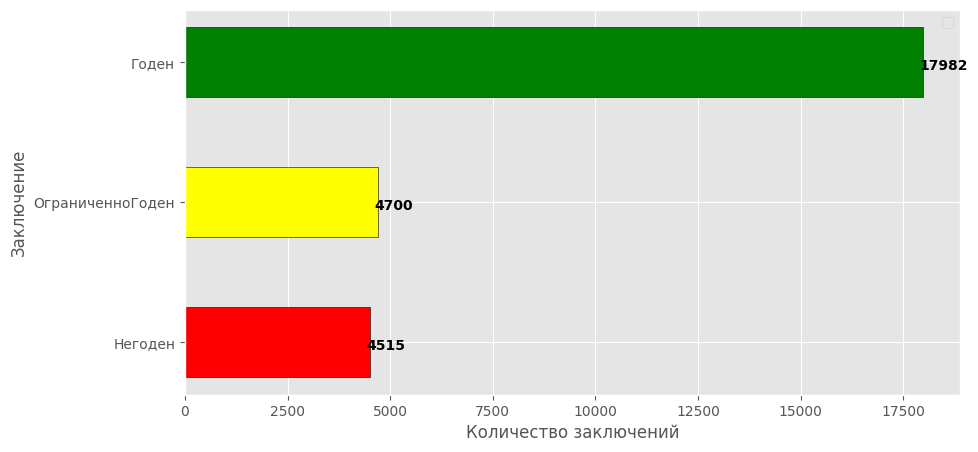

In [54]:
# Графическое представление:

y_axes = list(df_new['ЗаключениеМК'].value_counts().index.values)
x_axes = df_new['ЗаключениеМК'].value_counts().values
colors = ['green', 'yellow', 'r']
plt.figure(figsize = (10, 5))
plt.style.use('ggplot')
plt.barh(y_axes, x_axes, height=0.5, color=colors, edgecolor='black', linewidth=0.4)
for i, v in enumerate(x_axes):
    plt.text(v-85 if v>=90 else v+10, i + 0.05, str(v), color='black', fontweight='bold')
plt.gca().invert_yaxis()
plt.xlabel('Количество заключений')
plt.ylabel('Заключение')
plt.legend()
plt.show()

In [46]:
print(f'Не заполнено {round(df_new.isna().sum().sum() * 100 / df_new.size,2)} %')

Не заполнено 9.43 %


In [48]:
df_new.count()

AGE               27197
КлиентПол         27193
Цех                9975
Профессия         27197
ЗаключениеМК      27197
ВредныеФакторы    26464
MKB_ALL           27197
dtype: int64

In [50]:
df_new[['КлиентПол','Цех']] = df_new[['КлиентПол','Цех']].fillna('Нет данных')

In [51]:
df_new['ВредныеФакторы'] = df_new['ВредныеФакторы'].fillna('23')

In [52]:
print(f'Не заполнено {round(df_new.isna().sum().sum() * 100 / df_new.size,2)} %')

Не заполнено 0.0 %


In [53]:
df_new.to_csv('/content/drive/MyDrive/profpatolog/df_new.csv', index=False)

# Подготовка данных для нейронки

In [ ]:
df_new = pd.read_csv('/content/drive/MyDrive/profpatolog/df_new.csv')

In [56]:
# Проведем колонку "Профессия" через токенайзер отбросим числа, чтобы не учитывать разряды и номера категорий, а только сами специальности.
words_prof = 1890
tokenizer_prof = Tokenizer(num_words=words_prof, filters='i1234567890!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_prof.fit_on_texts(df_new['Профессия'].tolist())
max(tokenizer_prof.word_index.values())

1890

In [59]:
# Колонка "ВредныеФакторы" из фильтра исключим ".", чтобы индексы сохранились правильно
words_bed = 154
tokenizer_bed = Tokenizer(num_words=words_bed, filters='i!"#$%&()*+,-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='0.0.0', char_level=False)
tokenizer_bed.fit_on_texts(list(df_new['ВредныеФакторы']))
print(max(tokenizer_bed.word_index.values()))
print(tokenizer_bed.word_counts)

154
OrderedDict([('3.1.7', 1050), ('5.1', 7941), ('6.1', 4863), ('11.1', 6007), ('23', 5944), ('18.2', 2499), ('18.1', 4057), ('18', 687), ('4.3.2', 2349), ('11.3', 1192), ('11.4', 3946), ('1.30.1', 445), ('1.50', 2236), ('4.4', 6467), ('6.2', 3410), ('3.1.2', 826), ('4.3.1', 2111), ('6', 3028), ('11', 821), ('27', 1052), ('1.5', 574), ('1.37.2', 541), ('3.1', 602), ('17', 1916), ('15', 2595), ('4.2.5', 4504), ('9', 2912), ('4.3', 200), ('1.8.1.1', 199), ('1.48', 118), ('4.8', 1327), ('24', 162), ('13', 990), ('1.36', 92), ('4.7', 2725), ('25', 1140), ('1.39', 900), ('12', 739), ('1.52', 16), ('4.9', 418), ('1.1', 1076), ('1.3', 378), ('5.2.1', 332), ('1.2', 140), ('4.2.4', 154), ('4.10', 143), ('5.2', 517), ('3.1.9.3', 17), ('8', 457), ('26', 783), ('1.8.1.2', 86), ('1.8.2.1', 50), ('1.8.2.2', 26), ('1.8.3.1', 26), ('1.8.3.2', 26), ('4.2.1', 568), ('4.2.3', 231), ('4.5', 149), ('1.29.2', 623), ('4.1', 621), ('1.34.1', 169), ('1.37.1', 339), ('1.14', 5), ('1.17', 93), ('1.23', 377), ('

In [61]:
# Колонка "MKB_ALL" из фильтра исключим ".", чтобы индексы сохранились правильно
words_mkb = 354
tokenizer_mkb = Tokenizer(num_words=words_mkb, filters='i!"#$%&()*+,-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='0.0.0', char_level=False)
tokenizer_mkb.fit_on_texts(list(df_new['MKB_ALL']))
print(max(tokenizer_mkb.word_index.values()))
print(tokenizer_mkb.word_counts)

354
OrderedDict([('z99.9', 27197), ('z00.0', 22626), ('g40.9', 105), ('h52.0', 1640), ('h52.1', 5046), ('h52.2', 1700), ('f06.6', 350), ('11.9', 4504), ('n70.9', 57), ('h90.4', 57), ('f60.3', 223), ('k26.7', 179), ('f10.3', 420), ('k02.1', 111), ('k26.9', 329), ('45.6', 106), ('h25.0', 49), ('h53.0', 106), ('25.8', 134), ('h74.8', 12), ('k29.3', 711), ('12.9', 2), ('k80.1', 8), ('h90.3', 243), ('n90.4', 110), ('25.9', 139), ('k31.7', 2), ('77.9', 210), ('72.1', 210), ('h40.9', 114), ('h11.1', 106), ('k29.5', 246), ('b35.6', 214), ('r73.9', 386), ('h25', 214), ('f06.8', 225), ('n95.1', 3), ('c53.9', 2), ('j44.9', 3), ('f70.0', 213), ('h74.1', 195), ('j33.0', 132), ('48.2', 105), ('48.0', 105), ('h66.2', 106), ('k25.9', 2), ('k29.6', 223), ('e14.9', 33), ('d25', 175), ('g90.9', 50), ('h18.6', 7), ('l40.0', 48), ('49.8', 114), ('m42.1', 60), ('g90.8', 46), ('n60.2', 71), ('h35.0', 10), ('k81.1', 15), ('d25.9', 104), ('k29.9', 12), ('h33.0', 105), ('h51.9', 6), ('l40.9', 5), ('h91.1', 128)

In [63]:
# Проведем колонку "Профессия" через токенайзер отбросим числа, чтобы не учитывать разряды и номера категорий, а только сами специальности.
words_ceh = 657
tokenizer_ceh = Tokenizer(num_words=words_ceh, filters='i1234567890!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_ceh.fit_on_texts(df_new['Цех'].tolist())
max(tokenizer_ceh.word_index.values())

657

In [71]:
# Колонки АНЕ
x_data, list_code, list_encode = df_to_ohe(df_new,['AGE','КлиентПол'])
print(x_data1.shape)

(27197, 14)


In [67]:
# Отдельно преобразуем целевую колонку
y_data, y_code, y_encode = df_to_ohe(df_new,['ЗаключениеМК'])
print(y_data.shape)

(27197, 3)


In [70]:
# Получение BagOfWords по колонкам "Профессия", "ВредныеФакторы", "MKB_ALL", "Цех"
bow_prof = tokenizer_prof.texts_to_matrix(df_new['Профессия'].tolist())
bow_bed = tokenizer_bed.texts_to_matrix(df_new['ВредныеФакторы'].tolist())
bow_ceh = tokenizer_ceh.texts_to_matrix(df_new['Цех'].tolist())
bow_mkb = tokenizer_mkb.texts_to_matrix(df_new['MKB_ALL'].tolist())
print(bow_prof.shape, bow_bed.shape, bow_ceh.shape, bow_mkb.shape, sep='\n')

(27197, 1890)
(27197, 154)
(27197, 657)
(27197, 354)


In [72]:
x_data1 = np.hstack([x_data, bow_mkb])
x_data1.shape

(27197, 368)

In [73]:
x_data2 = np.hstack([bow_prof, bow_bed, bow_ceh])
x_data2.shape

(27197, 2701)

# Построение модели

In [74]:
mycolback = ModelCheckpoint('/content/drive/MyDrive/profpatolog/best_new.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [75]:
# Создание разветвленной модели
input_x1 = Input(shape=(x_data1.shape[1]), name = 'input_x1')
x1 = Dense(256, activation = 'relu', name = 'Dense1_x1') (input_x1)
x1 = Dropout(0.4, name = 'Dropout1_x1') (x1)
x1 = Dense(128, activation = 'relu', name = 'Dense2_x1') (x1)

input_x2 = Input(shape=(x_data2.shape[1]), name = 'input_x2')
x2 = Dense(1000, activation = 'relu', name = 'Dense1_x2') (input_x2)
x2 = Reshape((1000,1)) (x2)
#x2 = Conv1D(20, 5, activation='relu') (x2)
x2 = Conv1D(10, 5, activation='relu') (x2)
x2 = SpatialDropout1D(0.4) (x2)
x2 = MaxPool1D(4) (x2)
x2 = Flatten() (x2)
x2 = Dropout(0.4, name = 'Dropout1_x2') (x2)
x2 = Dense(64, activation = 'relu', name = 'Dense2_x2') (x2)

x = concatenate([x1, x2])

x = Dense(128, activation='relu') (x)

x = Dropout(0.3) (x)

output = Dense(3, activation='softmax', name = 'output') (x)

model = Model ([input_x1, input_x2], output)

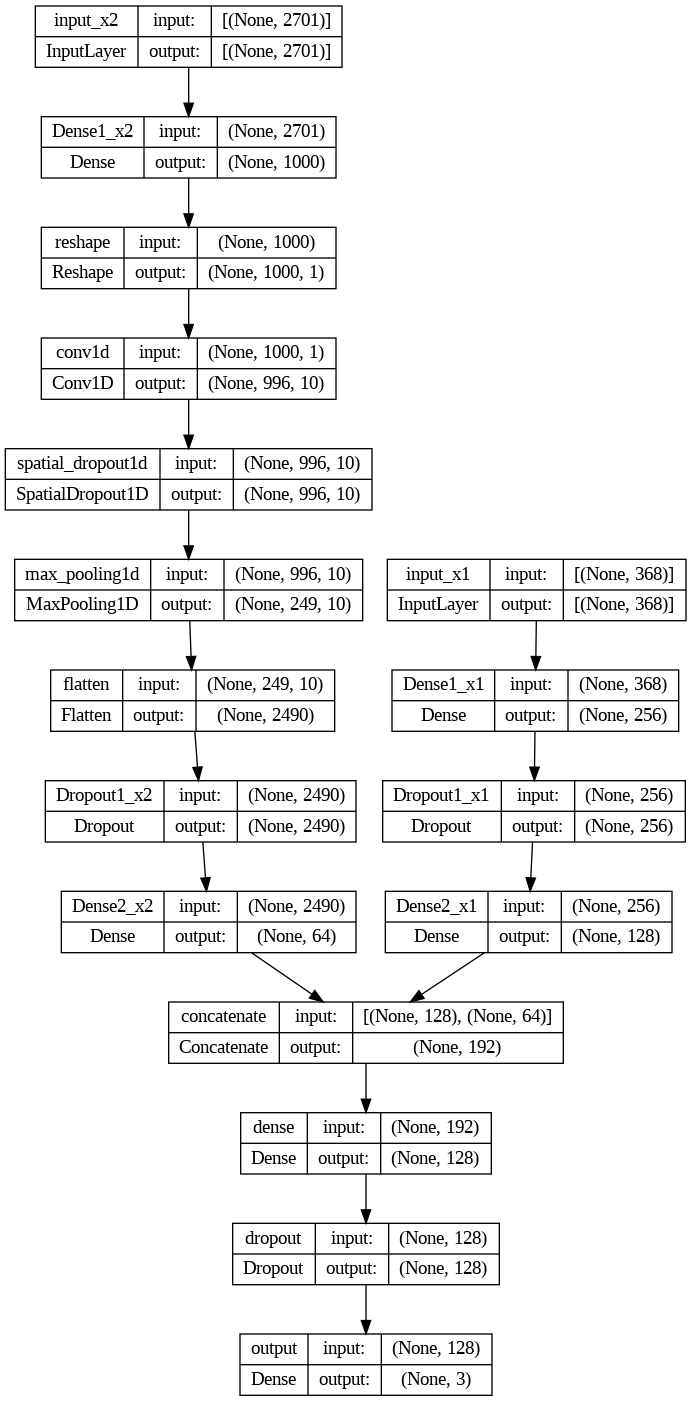

In [76]:
# Её структура
utils.plot_model(model, show_shapes=True)

In [77]:
# Компиляция и обучение
#model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[Precision()])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=3),'accuracy'])
history1 = model.fit({'input_x1':x_data1,'input_x2':x_data2}, y_data, batch_size=64, validation_split=0.2, epochs=40, verbose=1, callbacks=mycolback, shuffle=True)

Epoch 1/40
340/340 [==============================] - ETA: 0s - loss: 0.7132 - f1_score: 0.4866 - accuracy: 0.7042
Epoch 1: val_accuracy improved from -inf to 0.86563, saving model to /content/drive/MyDrive/profpatolog/best_new.h5
340/340 [==============================] - 33s 90ms/step - loss: 0.7132 - f1_score: 0.4866 - accuracy: 0.7042 - val_loss: 0.3330 - val_f1_score: 0.8273 - val_accuracy: 0.8656
Epoch 2/40
340/340 [==============================] - ETA: 0s - loss: 0.2819 - f1_score: 0.8554 - accuracy: 0.8838
Epoch 2: val_accuracy improved from 0.86563 to 0.90919, saving model to /content/drive/MyDrive/profpatolog/best_new.h5
340/340 [==============================] - 32s 94ms/step - loss: 0.2819 - f1_score: 0.8554 - accuracy: 0.8838 - val_loss: 0.2129 - val_f1_score: 0.8957 - val_accuracy: 0.9092
Epoch 3/40
340/340 [==============================] - ETA: 0s - loss: 0.2084 - f1_score: 0.8973 - accuracy: 0.9133
Epoch 3: val_accuracy improved from 0.90919 to 0.92224, saving model t

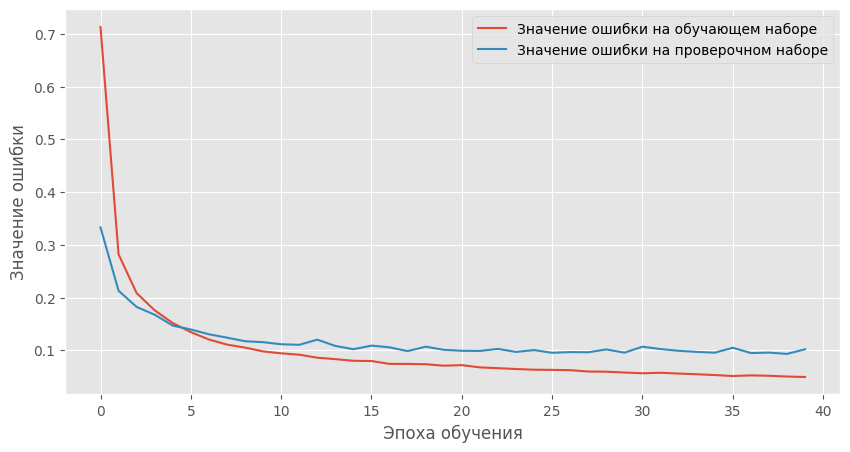

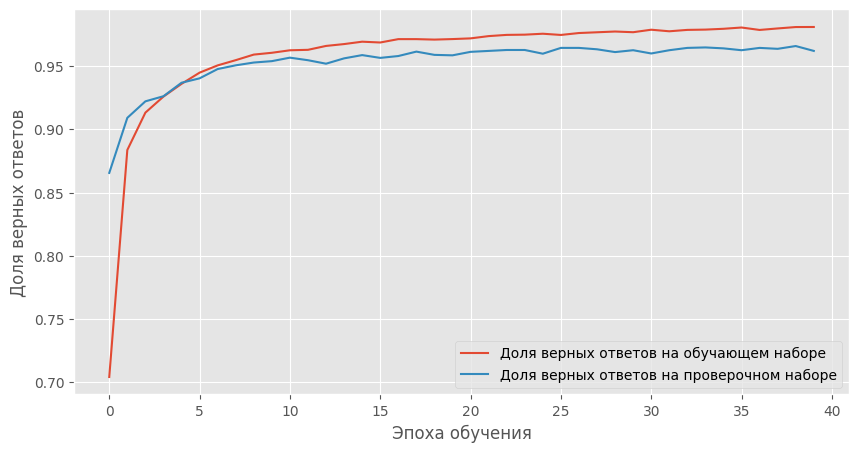

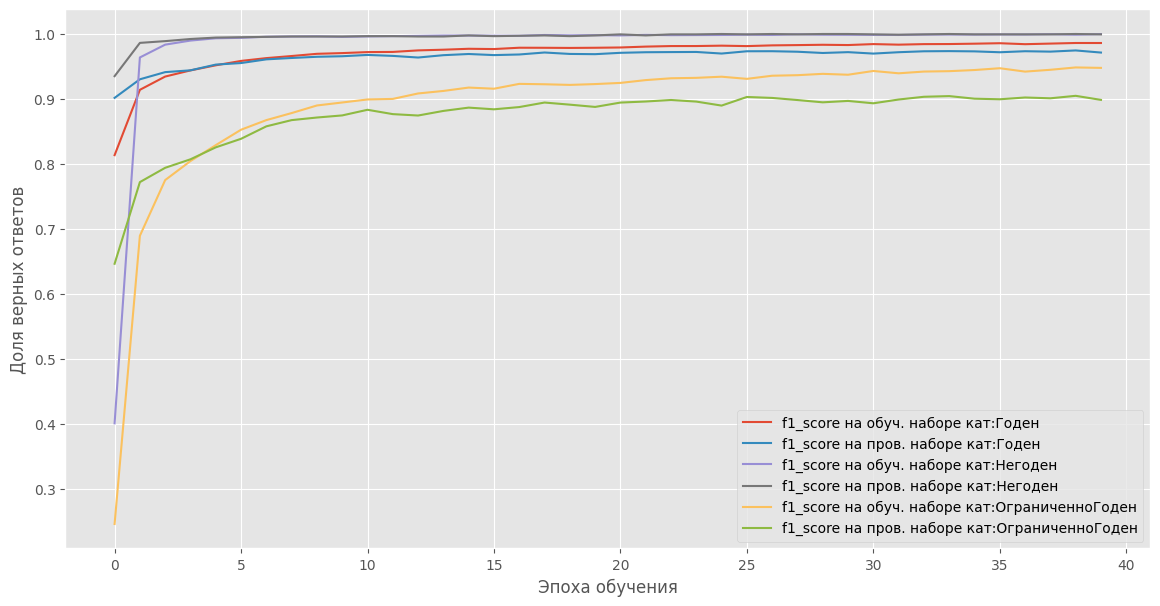

In [78]:
kat = y_encode['ЗаключениеМК'].classes_
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history1.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.style.use('ggplot')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

# Строим график для отображения динамики обучения метрика "F1Score" по каждому классу
plt.figure(figsize = (14, 7))
for i in range(3):
    plt.plot([history1.history['f1_score'][l][i]  for l in range(len(history1.history['f1_score']))],
             label=f'f1_score на обуч. наборе кат:{kat[i]}')
    plt.plot([history1.history['val_f1_score'][l][i]  for l in range(len(history1.history['f1_score']))],
             label=f'f1_score на пров. наборе кат:{kat[i]}')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

In [79]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/profpatolog/best_new.h5')

1/1 [==============================] - 7s 7s/step


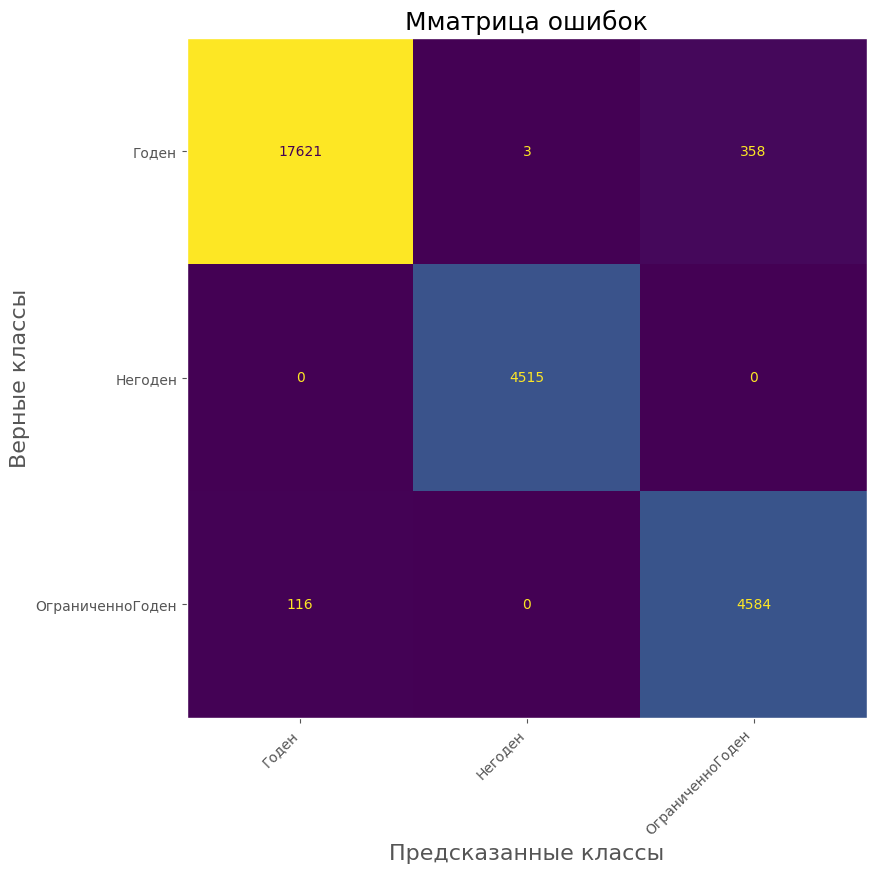

In [80]:
# Вывод матрицы ошибок предсказания
x = {'input_x1':x_data1,'input_x2':x_data2}
# Вычисление предсказания сети
y_pred = model.predict(x,batch_size=x_data1.shape[0])
# Построение матрицы ошибок
cm = confusion_matrix(np.argmax(y_data, axis=1),
                      np.argmax(y_pred, axis=1))
# Округление значений матрицы ошибок если применена нормализация
#cm = np.around(cm, 2)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Мматрица ошибок', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kat)
disp.plot(ax=ax)
plt.style.use('fivethirtyeight')
plt.grid(None)
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)
plt.show()